# Classifying Images using Dropout and Batchnorm Layer

## Learning objectives

* Image resizing.
* Train and evaluate a Neural Network (NN) model.
* Hyperparameter tuning with Keras Tuner.
* Apply dropout and batchnorm layer

## Introduction

In this notebook, you learn how to build a neural network to classify the tf-flowers dataset using dropout and batchnorm layer.

You can refer the companion notebook
[02a_machine_perception.ipynb](https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/02_ml_models/02a_machine_perception.ipynb) in which much of the data exploration was done.

Each learning objective will correspond to a __#TODO__ in the notebook where you will complete the notebook cell's code before running. Refer to the solution for reference.

In [2]:
import tensorflow as tf
print(tf.version.VERSION)

2.6.0


## Image resizing
Resize images to size using the specified method.

In [3]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2021-10-12 15:40:10.286216: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Train and evaluate a Neural Network (NN) model

Adding one non-linear layer in the middle ...

In [5]:
BATCH_SIZE = 32

train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

# NN with one hidden layer
model = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
          tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
          tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

2021-10-12 15:40:16.250584: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
104/104 [==============================] - 155s 1s/step - loss: 9.2732 - accuracy: 0.2521 - val_loss: 1.5389 - val_accuracy: 0.3135
Epoch 2/10
104/104 [==============================] - 123s 1s/step - loss: 1.5876 - accuracy: 0.2382 - val_loss: 1.5700 - val_accuracy: 0.2135
Epoch 3/10
104/104 [==============================] - 121s 1s/step - loss: 1.5784 - accuracy: 0.2467 - val_loss: 1.5920 - val_accuracy: 0.2432
Epoch 4/10
104/104 [==============================] - 120s 1s/step - loss: 1.5577 - accuracy: 0.2458 - val_loss: 1.5377 - val_accuracy: 0.2189
Epoch 5/10
104/104 [==============================] - 119s 1s/step - loss: 1.5409 - accuracy: 0.2470 - val_loss: 1.5258 - val_accuracy: 0.2189
Epoch 6/10
104/104 [==============================] - 119s 1s/step - loss: 1.5398 - accuracy: 0.2406 - val_loss: 1.6140 - val_accuracy: 0.2351
Epoch 8/10
104/104 [==============================] - 123s 1s/step - loss: 1.5920 - accuracy: 0.2500 - val_loss: 1.5132 - val_accuracy: 0.2432

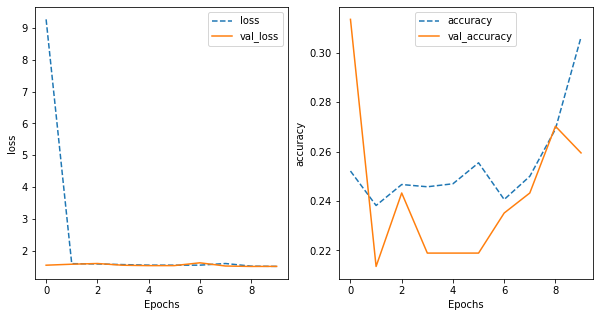

In [6]:
training_plot(['loss', 'accuracy'], history)

In [7]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001, # default in Adam constructor
                       l1 = 0,
                       l2 = 0,
                       num_hidden = 128):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  # NN with one hidden layers
  model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(len(CLASS_NAMES), 
                                    kernel_regularizer=regularizer,
                                    activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Epoch 1/10
104/104 [==============================] - 132s 1s/step - loss: 2.0127 - accuracy: 0.3506 - val_loss: 1.6493 - val_accuracy: 0.3351
Epoch 2/10
104/104 [==============================] - 121s 1s/step - loss: 1.4125 - accuracy: 0.4327 - val_loss: 1.5590 - val_accuracy: 0.3730
Epoch 3/10
104/104 [==============================] - 121s 1s/step - loss: 1.3266 - accuracy: 0.4658 - val_loss: 1.5073 - val_accuracy: 0.4054
Epoch 4/10
104/104 [==============================] - 121s 1s/step - loss: 1.2748 - accuracy: 0.4924 - val_loss: 1.5325 - val_accuracy: 0.3973
Epoch 5/10
104/104 [==============================] - 122s 1s/step - loss: 1.2402 - accuracy: 0.5076 - val_loss: 1.6302 - val_accuracy: 0.4081
Epoch 6/10
104/104 [==============================] - 121s 1s/step - loss: 1.2461 - accuracy: 0.5233 - val_loss: 1.4928 - val_accuracy: 0.4189
Epoch 7/10
104/104 [==============================] - 125s 1s/step - loss: 1.1489 - accuracy: 0.5612 - val_loss: 1.4195 - val_accuracy: 0.4459

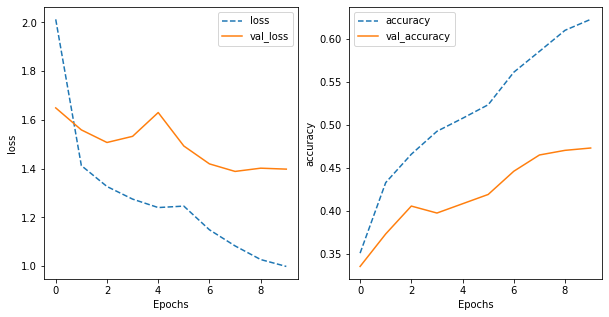

In [8]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=128)

Epoch 1/10
104/104 [==============================] - 137s 1s/step - loss: 3.0252 - accuracy: 0.3321 - val_loss: 1.9387 - val_accuracy: 0.4243
Epoch 2/10
104/104 [==============================] - 127s 1s/step - loss: 1.5079 - accuracy: 0.4264 - val_loss: 1.8902 - val_accuracy: 0.3946
Epoch 3/10
104/104 [==============================] - 128s 1s/step - loss: 1.3923 - accuracy: 0.4694 - val_loss: 1.8609 - val_accuracy: 0.3919
Epoch 4/10
104/104 [==============================] - 129s 1s/step - loss: 1.2904 - accuracy: 0.5052 - val_loss: 1.9687 - val_accuracy: 0.4054
Epoch 5/10
104/104 [==============================] - 127s 1s/step - loss: 1.2871 - accuracy: 0.5261 - val_loss: 2.3090 - val_accuracy: 0.4054
Epoch 6/10
104/104 [==============================] - 127s 1s/step - loss: 1.2536 - accuracy: 0.5455 - val_loss: 2.3322 - val_accuracy: 0.4270
Epoch 7/10
104/104 [==============================] - 130s 1s/step - loss: 1.2292 - accuracy: 0.5518 - val_loss: 2.4443 - val_accuracy: 0.4108

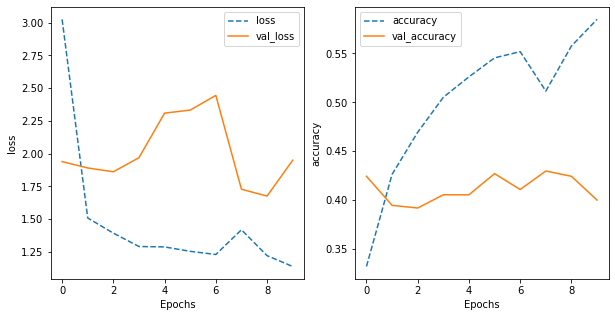

In [10]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=256)

Epoch 1/10
104/104 [==============================] - 124s 1s/step - loss: 2.2927 - accuracy: 0.3688 - val_loss: 2.0093 - val_accuracy: 0.3432
Epoch 2/10
104/104 [==============================] - 122s 1s/step - loss: 1.6708 - accuracy: 0.4282 - val_loss: 2.4891 - val_accuracy: 0.3568
Epoch 3/10
104/104 [==============================] - 123s 1s/step - loss: 1.7036 - accuracy: 0.4452 - val_loss: 1.7967 - val_accuracy: 0.4162
Epoch 4/10
104/104 [==============================] - 125s 1s/step - loss: 1.4870 - accuracy: 0.5073 - val_loss: 1.8860 - val_accuracy: 0.4108
Epoch 5/10
104/104 [==============================] - 122s 1s/step - loss: 1.4675 - accuracy: 0.5227 - val_loss: 1.5838 - val_accuracy: 0.4432
Epoch 6/10
104/104 [==============================] - 123s 1s/step - loss: 1.3861 - accuracy: 0.5330 - val_loss: 1.6676 - val_accuracy: 0.4486
Epoch 7/10
104/104 [==============================] - 122s 1s/step - loss: 1.2894 - accuracy: 0.5706 - val_loss: 1.6727 - val_accuracy: 0.4541

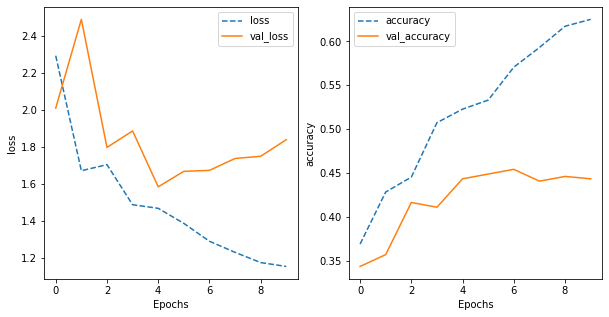

In [11]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0.001, num_hidden=128)

## Hyperparameter tuning with Keras Tuner

The Keras Tuner is a library that helps you pick the optimal set of hyperparameters for your TensorFlow program. The process of selecting the right set of hyperparameters for your machine learning (ML) application is called hyperparameter tuning. You are going to use the Keras Tuner to perform hypertuning for an image classification application.

In [13]:
!pip install --quiet keras-tuner

In [14]:
import kerastuner as kt

# parameterize to the values in the previous cell
def build_model(hp):
  lrate = hp.Float('lrate', 1e-4, 1e-1, sampling='log')
  l1 = 0
  l2 = hp.Choice('l2', values=[0.0, 1e-1, 1e-2, 1e-3, 1e-4])
  num_hidden = hp.Int('num_hidden', 32, 256, 32)

  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  # NN with one hidden layers
  model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(len(CLASS_NAMES), 
                                    kernel_regularizer=regularizer,
                                    activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
  return model

batch_size = 32
train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(batch_size)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(32) # this doesn't matter

tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_accuracy', 'max'), 
    max_trials=10,
    num_initial_points=2, 
    overwrite=False) # True to start afresh.

tuner.search(
    train_dataset, validation_data=eval_dataset,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)]
)

topN = 1
for x in range(topN):
  print(tuner.get_best_hyperparameters(topN)[x].values)
  print(tuner.get_best_models(topN)[x].summary())

Trial 10 Complete [00h 03m 52s]
val_accuracy: 0.4702702760696411

Best val_accuracy So Far: 0.4864864945411682
Total elapsed time: 01h 03m 50s
INFO:tensorflow:Oracle triggered exit
{'lrate': 0.0001, 'l2': 0.0001, 'num_hidden': 256}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               38535424  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 38,536,709
Trainable params: 38,536,709
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
topN = 1
for x in range(topN):
  print(tuner.get_best_hyperparameters(topN)[x].values)
  print(tuner.get_best_models(topN)[x].summary())
  

{'lrate': 0.0001, 'l2': 0.0001, 'num_hidden': 256}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               38535424  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 38,536,709
Trainable params: 38,536,709
Non-trainable params: 0
_________________________________________________________________
None


The best set of hyperparameters: 
* l2=0, lrate=0.00017, num_hidden=64 score=0.4595

## Apply dropout and batchnorm layer
Dropouts are the regularization technique that is used to prevent overfitting in the model. Batch normalization is a layer that allows every layer of the network to do learning more independently. The layer is added to the sequential model to standardize the input or the outputs. Add a dropout and batchnorm layer after each of the hidden layers.


In [18]:
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       dropout_prob = 0.4,
                       num_hidden = [64, 16]):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  # NN with multiple hidden layers
  layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='input_pixels')]
  for hno, nodes in enumerate(num_hidden):
    layers.extend([
      tf.keras.layers.Dense(nodes,
                            kernel_regularizer=regularizer, 
                            name='hidden_dense_{}'.format(hno)),
      tf.keras.layers.BatchNormalization(scale=False, # ReLU
                                         center=False, # have bias in Dense
                                         name='batchnorm_dense_{}'.format(hno)),
      #move activation to come after batchnorm
      tf.keras.layers.Activation('relu', name='relu_dense_{}'.format(hno)),
      tf.keras.layers.Dropout(rate=dropout_prob,
                             name='dropout_dense_{}'.format(hno)),                         
    ])

  layers.append(
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  )

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_pixels (Flatten)       (None, 150528)            0         
_________________________________________________________________
hidden_dense_0 (Dense)       (None, 64)                9633856   
_________________________________________________________________
batchnorm_dense_0 (BatchNorm (None, 64)                128       
_________________________________________________________________
relu_dense_0 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_dense_0 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                1040      
_________________________________________________________________
batchnorm_dense_1 (BatchNorm (None, 16)      

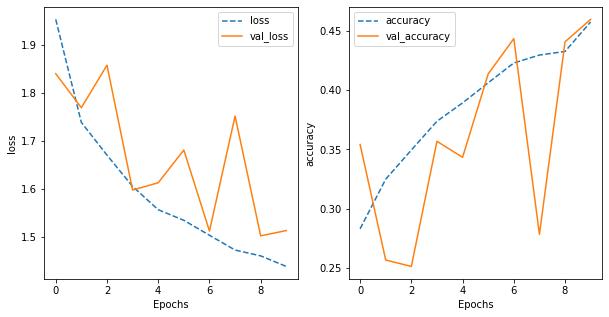

In [20]:
model = train_and_evaluate(dropout_prob=0.4)

## Diagrams

These plot the diagrams in the book.

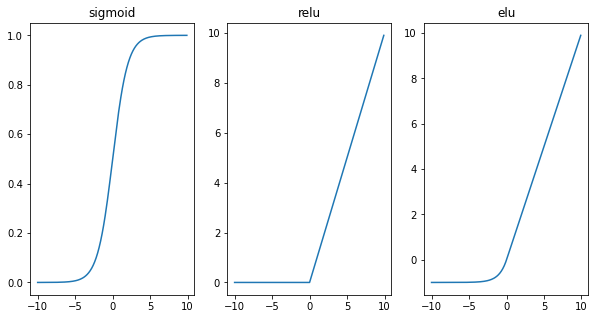

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 3, figsize=(10,5))
x = np.arange(-10.0, 10.0, 0.1)
y = tf.keras.activations.sigmoid(x)
ax[0].plot(x, y);
ax[0].set_title("sigmoid")
y = tf.keras.activations.relu(x)
ax[1].plot(x, y);
ax[1].set_title("relu")
y = tf.keras.activations.elu(x)
ax[2].plot(x, y);
ax[2].set_title("elu");

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               19267712  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 19,268,357
Trainable params: 19,268,357
Non-trainable params: 0
_________________________________________________________________


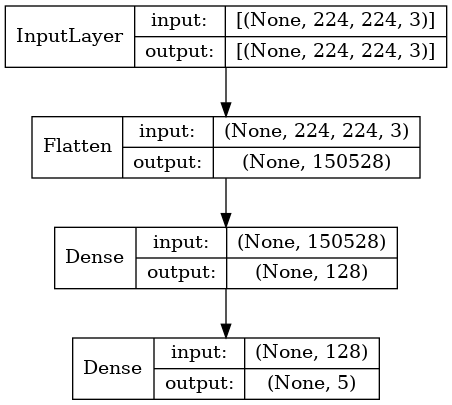

In [22]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
   tf.keras.layers.Dense(128, activation='relu'),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [23]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 752645    
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________
